In [87]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
import toolkit.allen_helpers.stimuli as st
import toolkit.analysis.spectrum as spec
from toolkit.paths import paths
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.pipeline.data_io import get_existing_sessions, get_session_selection, SessionDirectory
from toolkit.pipeline.signal import average_psd_across_sessions
from toolkit.plots import plots

In [ ]:
# from toolkit.utils.module import reload_module

### Config

In [3]:
session_set = 'all'  # 'all', 'selected', 'test'

ecephys_structure_acronym = GLOBAL_SETTINGS['ecephys_structure_acronym']

# get existing sessions in the data cache directory
session_list, missing_sessions = get_existing_sessions(session_set, structure_acronym=ecephys_structure_acronym)

sessions_df = get_session_selection().loc[session_list]
session_list = sessions_df.index[sessions_df['has_lfp_data']].tolist()

In [15]:
figsize = (3.2, 2.4)
plt_range = 100.  # PSD frequency range for plotting

### Load data

In [4]:
psd_dss = {}
cond_psd_das = {}
bands_dss = {}
cond_band_power_das = {}
session_types = {s: [] for s in sessions_df['session_type'].unique()}

for session_id in session_list:
    session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

    # load PSD
    if not session_dir.exist:
        print(f"Failed to load PSD for session {session_id}: session directory does not exist")
    elif not session_dir.has_lfp_data: # skip if no lfp data
        print(f"Failed to load PSD for session {session_id}: no lfp data")
    else:
        session_type = sessions_df.loc[session_id, 'session_type']
        psd_dss[session_id] = session_dir.load_psd()
        cond_psd_das[session_id] = session_dir.load_conditions_psd()
        bands_dss[session_id] = session_dir.load_bands()
        cond_band_power_das[session_id] = session_dir.load_condition_band_power(session_type=session_type)
        session_types[session_type].append(session_id)

session_list = list(psd_dss)

In [5]:
fss = np.array([ds.attrs['fs'] for ds in psd_dss.values()])
fs = np.round(np.median(fss))  # round to integer sampling rate

# check if all sampling rates are the same
if np.any(np.round(fss) != fs):
    raise ValueError(f'Inconsistent sampling rate found.')

nfft = next(iter(psd_dss.values())).attrs['nfft']
# check if all nffts are the same
if any(ds.attrs['nfft'] != nfft for ds in psd_dss.values()):
    raise ValueError(f'Inconsistent nfft found.')

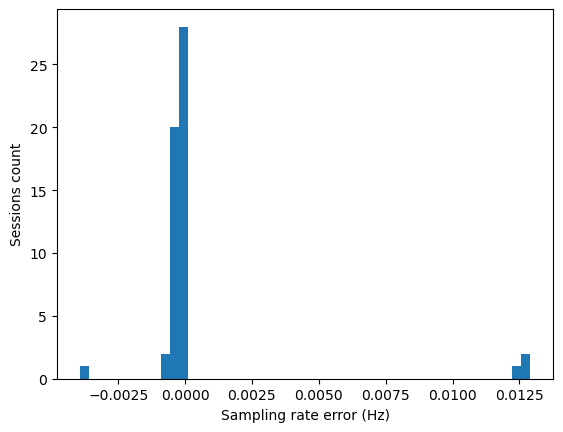

In [6]:
plt.hist(fss - fs, bins=50)
plt.xlabel('Sampling rate error (Hz)')
plt.ylabel('Sessions count')
plt.show()

#### Average PSD across sessions

In [82]:
psd_avg = {}
psd_ds = {}
bands_ds = {}
stim_cond_psd_das = {}
cond_psd_avg = {}

for session_type, session_ids in session_types.items():
    # average PSD across sessions
    psd_avg[session_type], psd_ds[session_type] = average_psd_across_sessions(
        (psd_dss[session_id] for session_id in session_ids), fs=fs, nfft=nfft
    )
    # combine bands of sessions
    bands_ds[session_type] = xr.concat(
        (bands_dss[session_id] for session_id in session_ids),
        data_vars=['bands', 'peaks', 'center_freq'],
        dim=pd.Index(session_ids, name='session_id')
    )
    # average drifting gratings conditions PSD across sessions
    for stim in st.STIMULUS_CATEGORIES[session_type]['drifting_gratings']:
        cond_psd_avg[stim], stim_cond_psd_das[stim] = average_psd_across_sessions(
            (cond_psd_das[session_id][stim] for session_id in session_ids), fs=fs, nfft=nfft
        )

#### Fooof parameters

In [83]:
bands_ds['brain_observatory_1.1']

<xarray.Dataset>
Dimensions:                (stimulus: 9, layer: 6, wave_band: 3, bound: 2,
                            peak_rank: 2, session_id: 31)
Coordinates:
  * stimulus               (stimulus) object 'flashes' ... 'natural_scenes'
  * layer                  (layer) object '1' '2/3' '4' '5' '6a' '6b'
  * wave_band              (wave_band) object 'beta' 'gamma' 'LGN gamma'
  * bound                  (bound) object 'lower' 'upper'
  * peak_rank              (peak_rank) int32 0 1
  * session_id             (session_id) int64 715093703 719161530 ... 799864342
Data variables:
    bands                  (session_id, stimulus, layer, wave_band, bound) float64 ...
    peaks                  (session_id, stimulus, layer, wave_band, peak_rank) float64 ...
    center_freq            (session_id, stimulus, layer, wave_band, peak_rank) float64 ...
    wave_band_limit        (wave_band, bound) float64 20.0 40.0 ... 50.0 70.0
    wave_band_width_limit  (wave_band, bound) float64 0.0 30.0 5.0 20.0 0.0 10.0
Attributes:
    peak_width_limits:  [ 0. inf]
    min_peak_height:    0.08
    peak_threshold:     1.0
    max_n_peaks:        10
    aperiodic_mode:     knee
    freq_range:         200.0
    dB_threshold:       0.8
    top_n_peaks:        2
    bandwidth_n_sigma:  1.5

In [88]:
ds = list(bands_ds.values())[0]
fooof_params = {k: ds.attrs[k] for k in [
    'freq_range', 'aperiodic_mode', 'peak_width_limits', 'max_n_peaks', 'dB_threshold', 'peak_threshold'
]}

wave_band_limit = ds.data_vars['wave_band_limit']
wave_band_width_limit = ds.data_vars['wave_band_width_limit']
freq_band_kwargs = {k: ds.attrs[k] for k in ['top_n_peaks', 'bandwidth_n_sigma']}

#### Fit FOOOF and get frequency bands

In [89]:
fooof_objs = {}
avg_bands_ds = {}

for session_type in session_types:
    psd_avg_ds = psd_avg[session_type]
    stimulus_names = list(psd_avg_ds.data_vars)
    layers = psd_avg_ds.coords['layer'].values

    bands = np.full((len(stimulus_names), layers.size, wave_band_limit.wave_band.size, 2), np.nan)
    peaks = np.full(bands.shape[:-1] + (freq_band_kwargs['top_n_peaks'], ), np.nan)
    center_freq = peaks.copy()

    fooof_objs[session_type] = {}
    for i, (stim, psd_avg_da) in enumerate(psd_avg_ds.items()):
        fooof_objs[session_type][stim] = {}
        for j, layer in enumerate(layers):
            psd_da = psd_avg_da.sel(layer=layer)

            # fit fooof
            fooof_result, fooof_objs[session_type][stim][layer], fooof_kwargs = spec.fit_fooof(psd_da, **fooof_params)
            gaussian_params = fooof_result.gaussian_params

            # get frequency bands
            for k, wave_band in enumerate(wave_band_limit.wave_band):
                band, peak_inds = spec.get_fooof_freq_band(
                    gaussian_params=gaussian_params,
                    freq_range=wave_band_limit.sel(wave_band=wave_band).values,
                    width_limit=wave_band_width_limit.sel(wave_band=wave_band).values,
                    **freq_band_kwargs
                )

                bands[i, j, k] = band
                peaks[i, j, k, :peak_inds.size] = gaussian_params[peak_inds, 1]
                center_freq[i, j, k, :peak_inds.size] = gaussian_params[peak_inds, 0]

    coords = dict(stimulus=stimulus_names, layer=layers, wave_band=wave_band_limit.coords['wave_band'])
    bands = xr.DataArray(data=bands, coords=coords | dict(bound=wave_band_limit.coords['bound']))
    peaks = xr.DataArray(data=peaks, coords=coords | dict(peak_rank=range(peaks.shape[-1])))
    center_freq = peaks.copy(data=center_freq)

    avg_bands_ds[session_type] = xr.Dataset(dict(
        bands=bands, peaks=peaks, center_freq=center_freq,
        wave_band_limit=wave_band_limit,
        wave_band_width_limit=wave_band_width_limit
    ))
    avg_bands_ds[session_type].attrs.update(fooof_kwargs | fooof_params | freq_band_kwargs)

### Plot average PSD of drifting gratings conditions

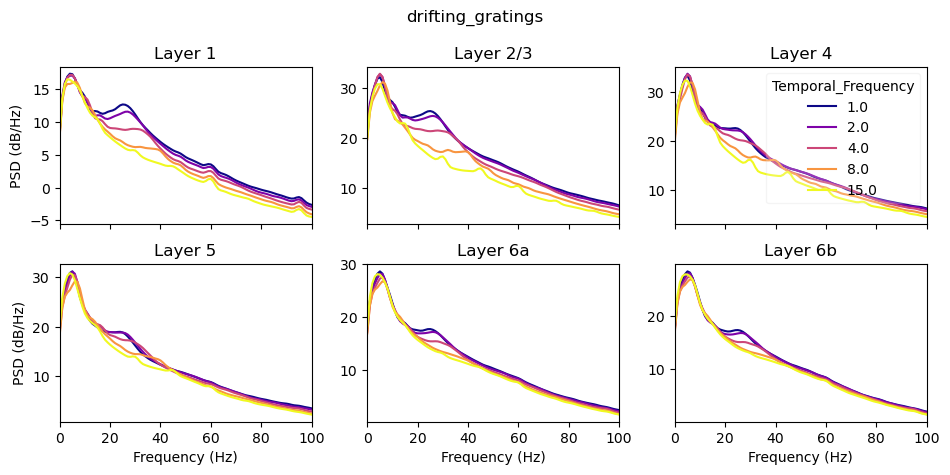

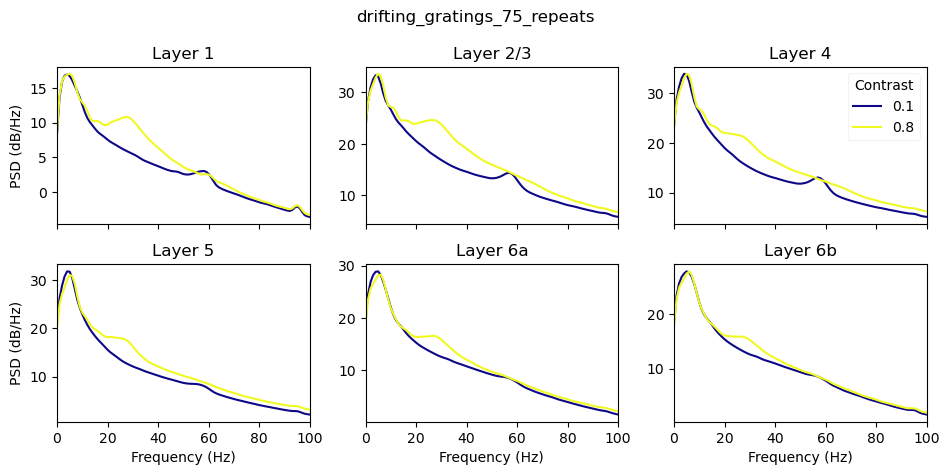

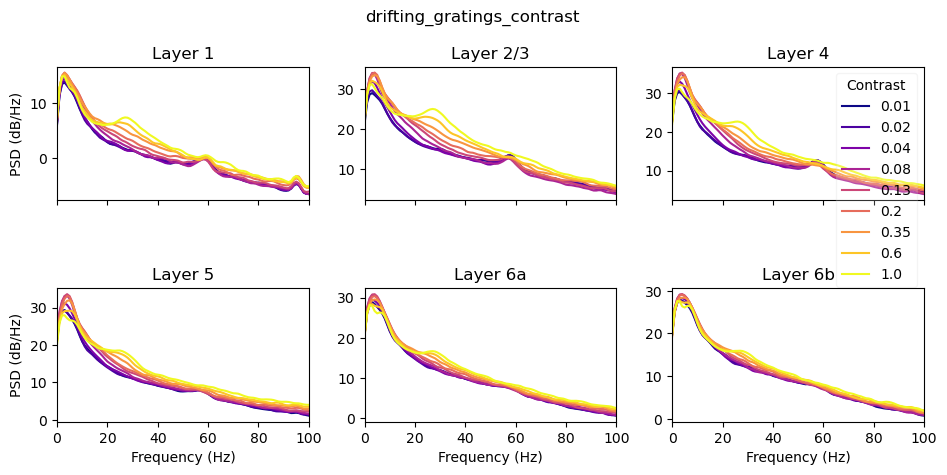

In [58]:
n_cols = 3
average_over = 'orientation'
condition_types = st.CONDITION_TYPES

for stim, da in cond_psd_avg.items():
    session_type = st.STIMULUS_SESSION_TYPES[stim]
    average_dims = st.FIXED_CONDITION_TYPES[session_type] + (average_over,)
    channel_dim = np.setdiff1d(condition_types, average_dims)[0]
    avg_da = da.mean(dim=average_dims)

    layers = avg_da.coords['layer'].values
    n_layers = len(layers)
    n_rows = np.ceil(n_layers / n_cols).astype(int)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(figsize[0] * n_cols, figsize[1] * n_rows),
        sharex=True, squeeze=False)
    for i, layer in enumerate(layers):
        ax = axs.ravel()[i]
        layer_da = avg_da.sel(layer=layer)
        plots.plot_channel_psd(layer_da, channel_dim=channel_dim, freq_range=plt_range, ax=ax)
        ax.set_title(f'Layer {layer}')

    for ax in axs.ravel()[n_layers:]:
        ax.remove()
    for ax in axs.ravel()[:n_layers]:
        if ax is not axs[0, -1]:
            ax.get_legend().remove()
    for ax in axs[:, 1:].ravel():
        ax.set_ylabel('')
    for ax in axs.ravel()[:n_layers - n_cols]:
        ax.set_xlabel('')
    fig.suptitle(stim)
    fig.tight_layout()
plt.show()

### Plot average PSD of stimuli

In [ ]:
# plots = reload_module("toolkit.plots.plots")

c:\Users\ziaochen\projects\neuroscience\Analyzing_Allen_Visual_Coding_Neuropixels_Dataset\toolkit\plots\plots.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  


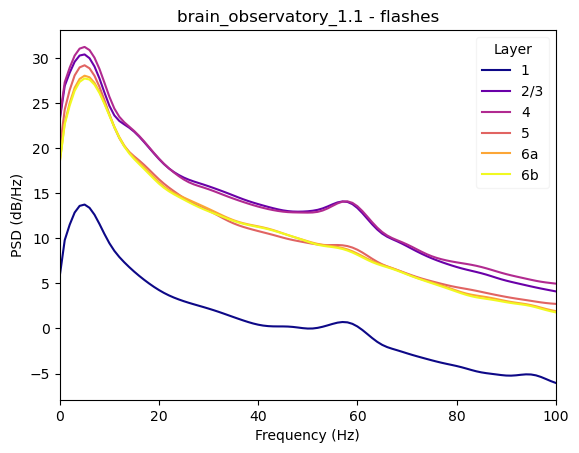

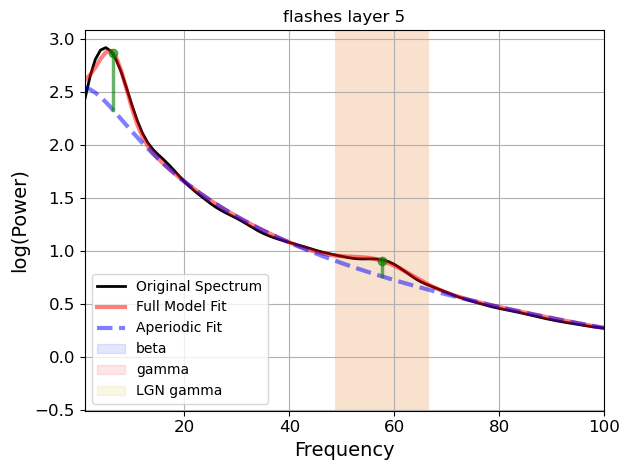

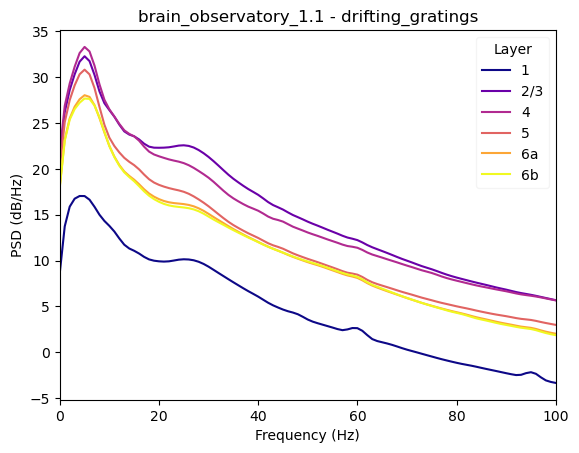

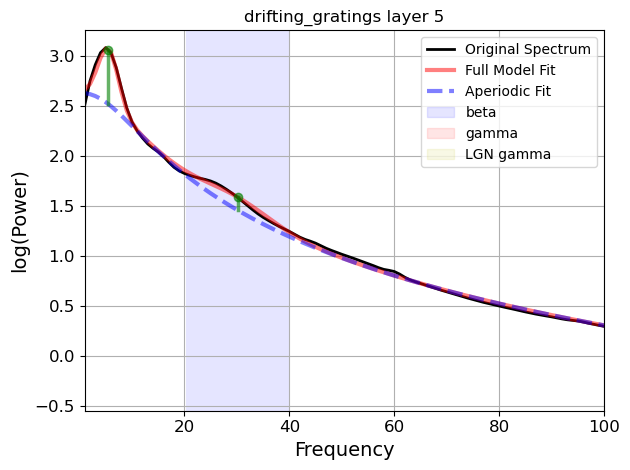

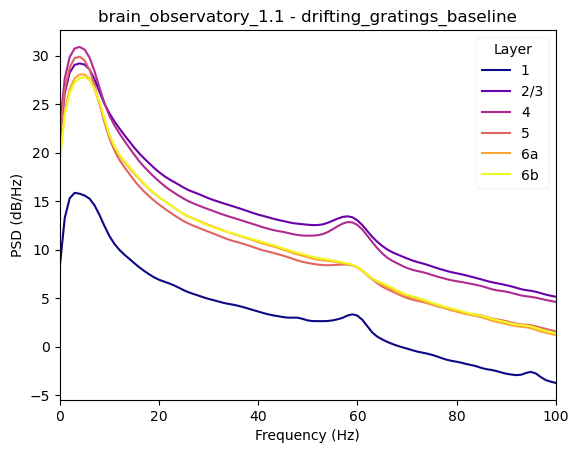

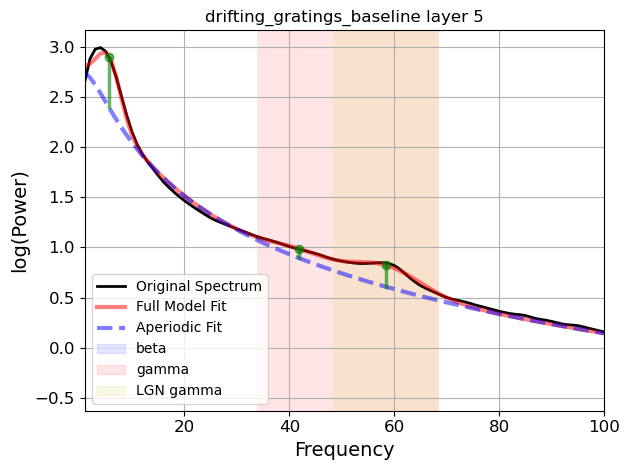

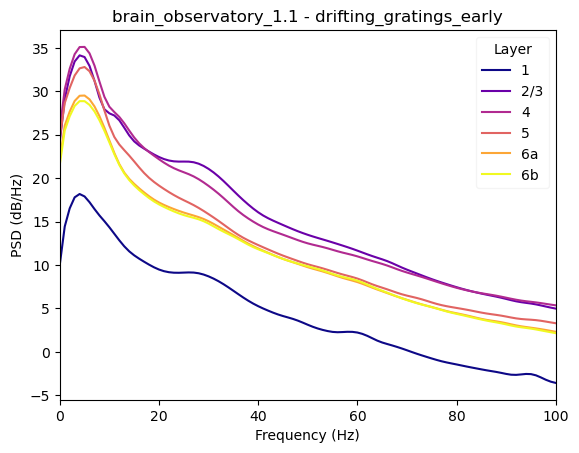

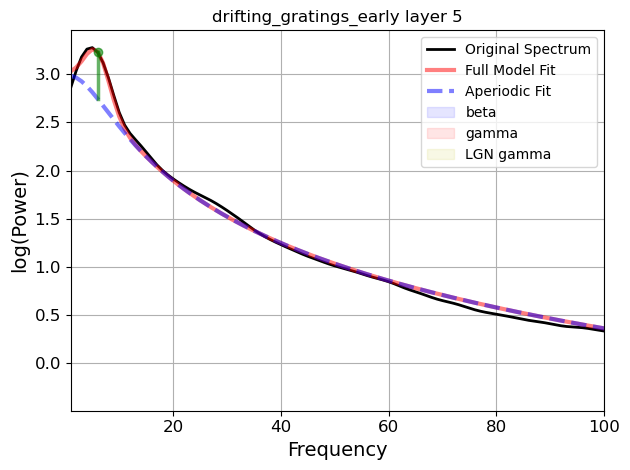

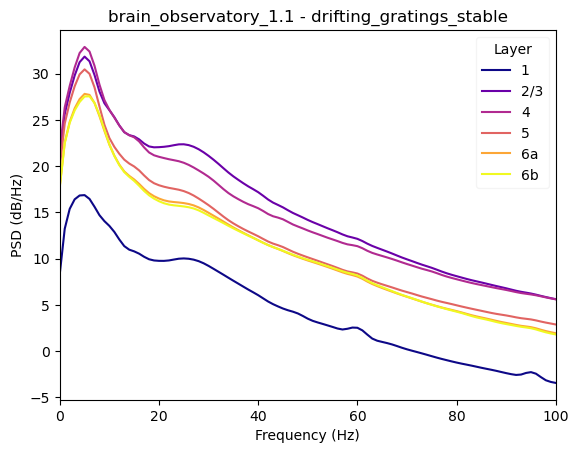

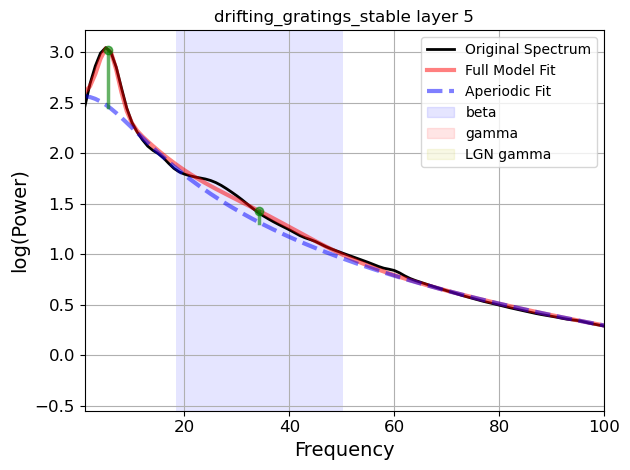

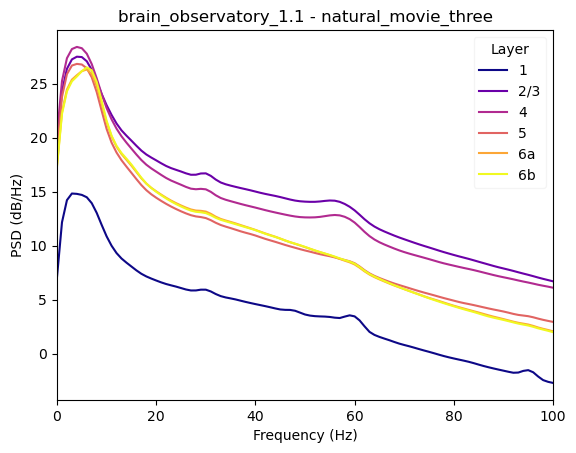

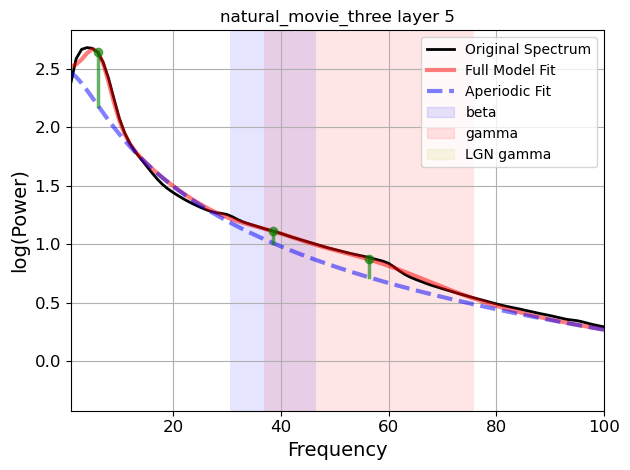

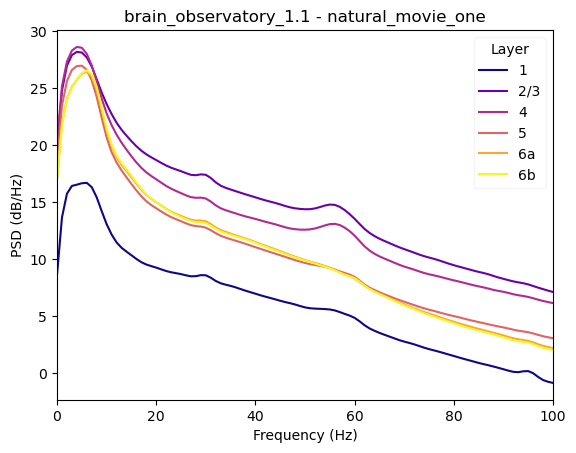

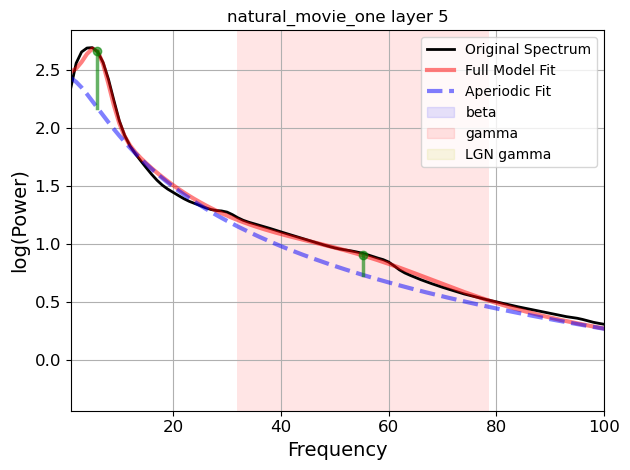

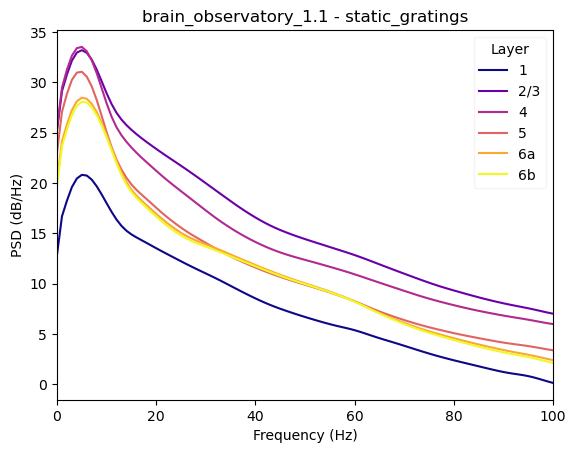

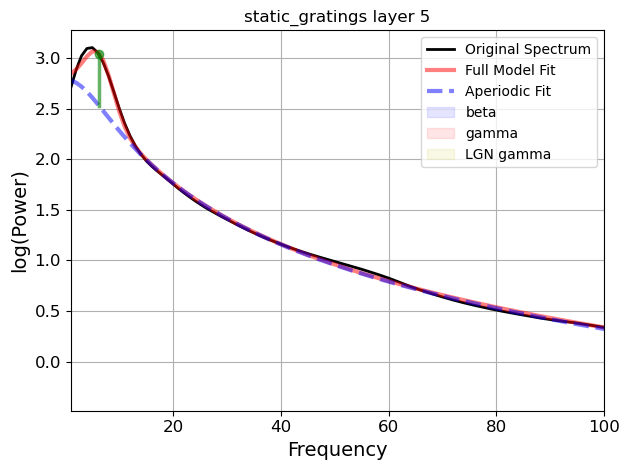

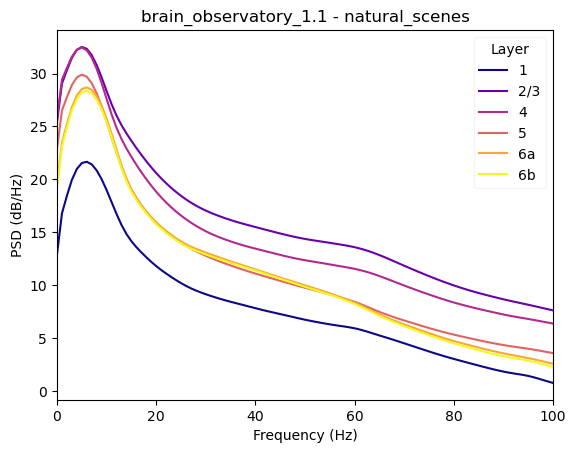

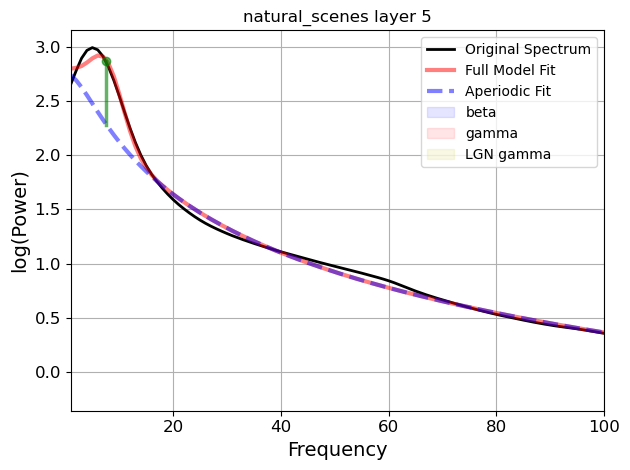

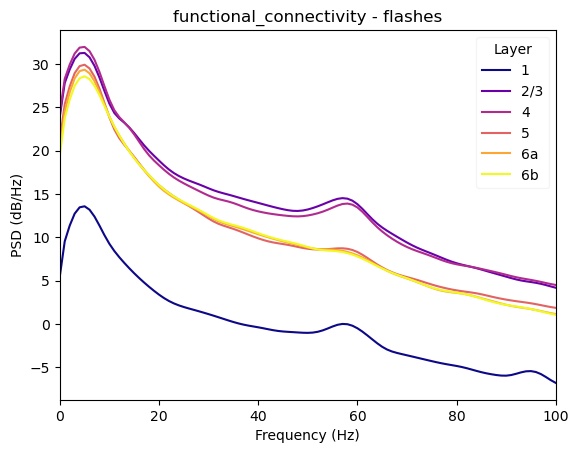

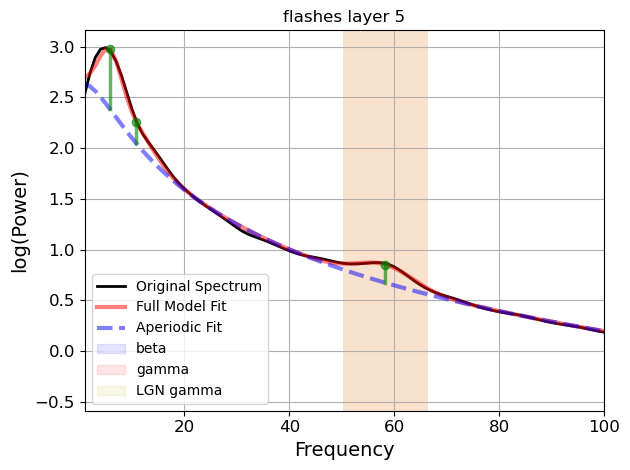

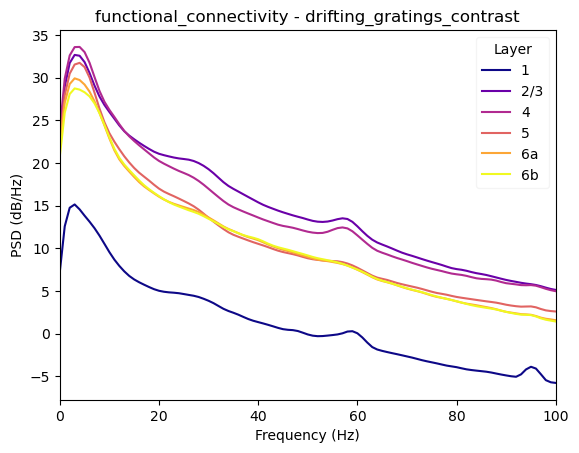

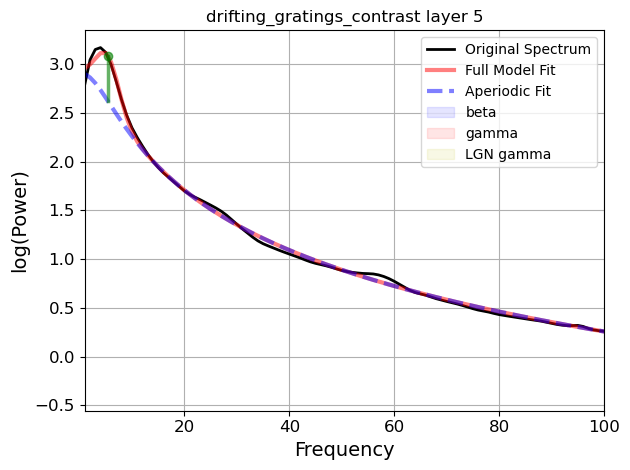

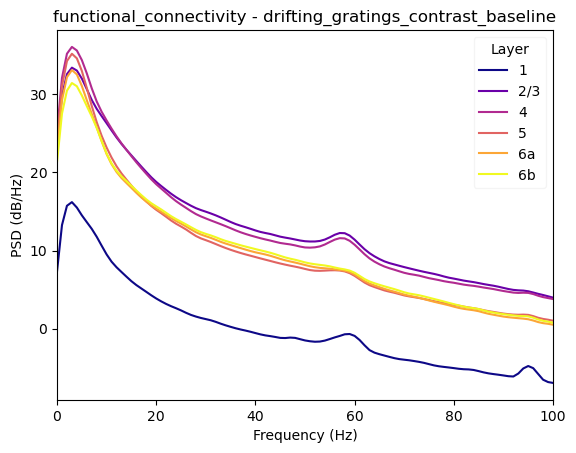

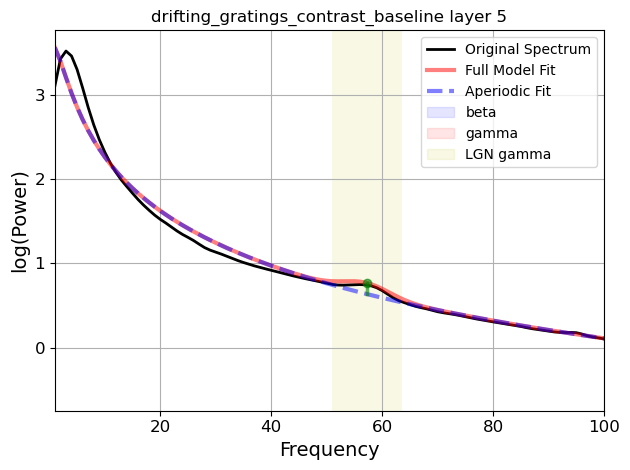

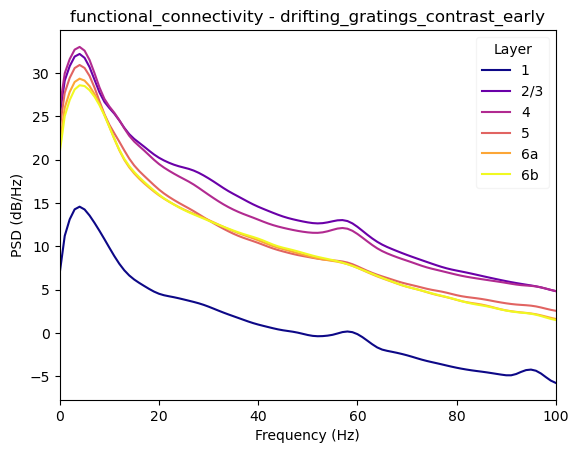

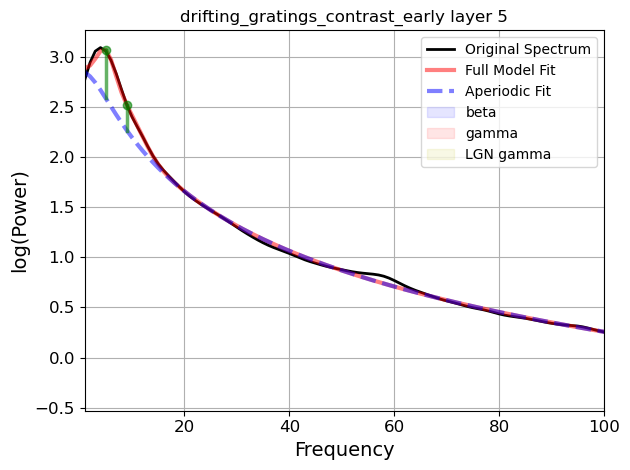

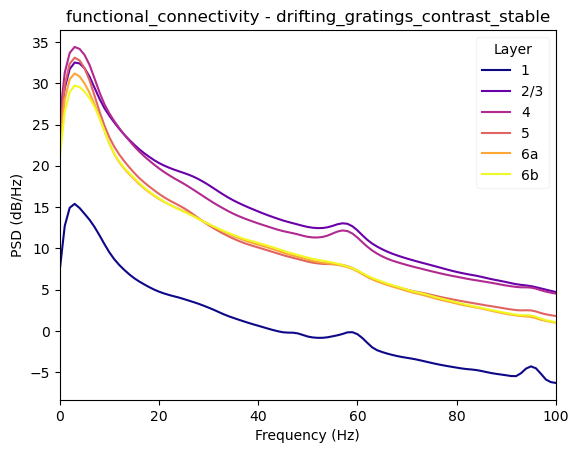

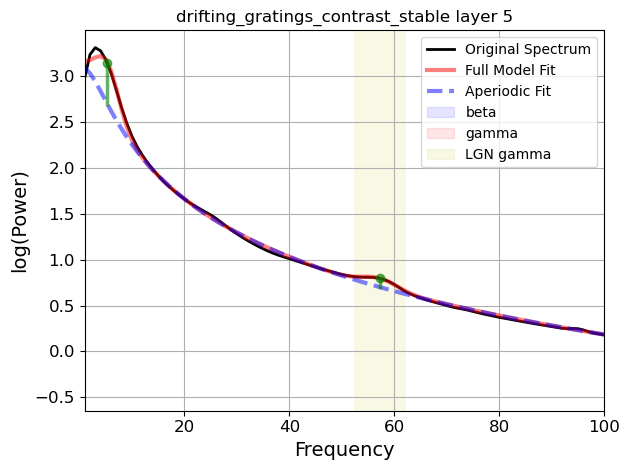

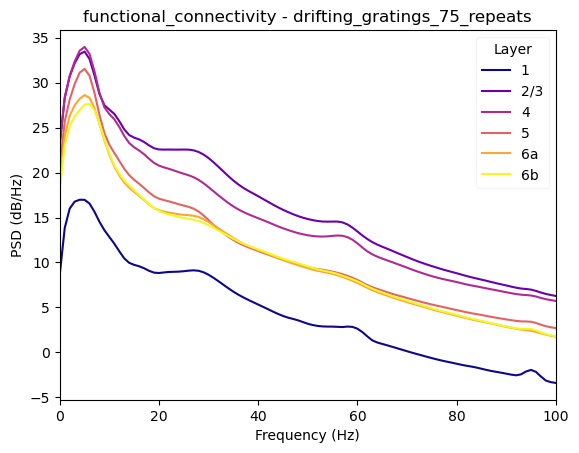

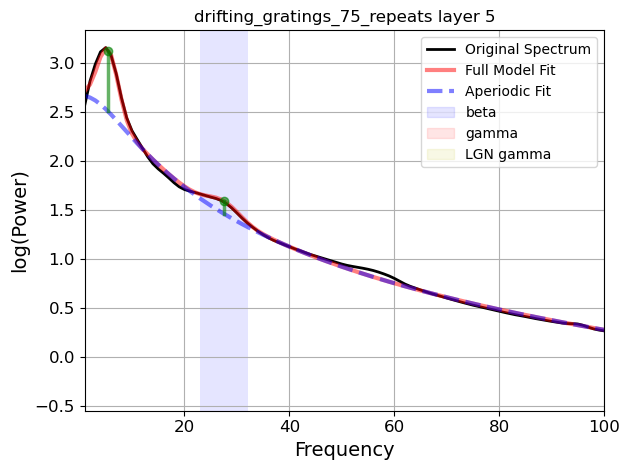

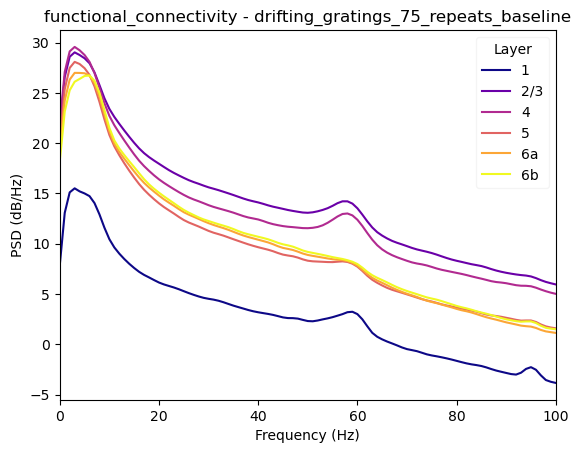

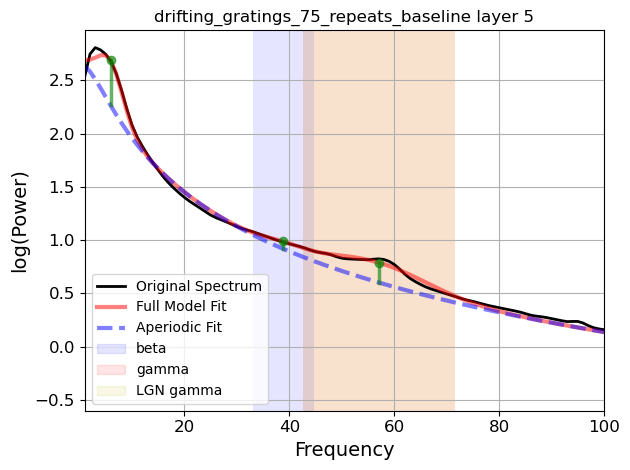

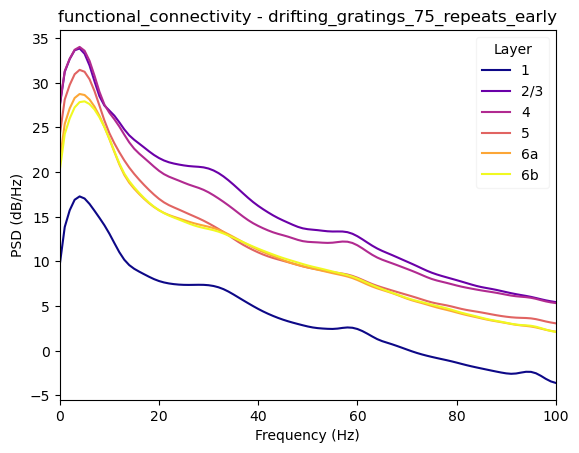

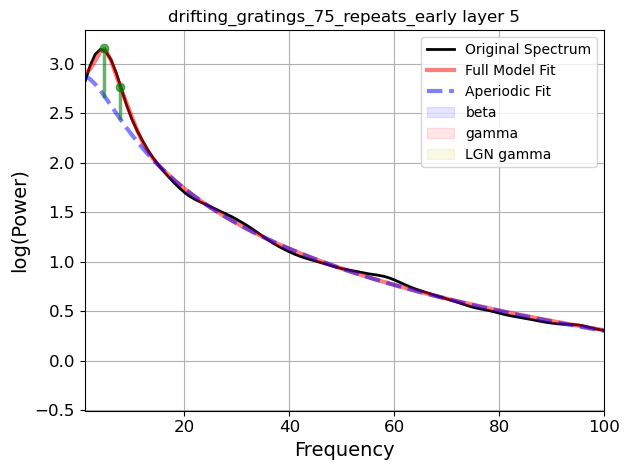

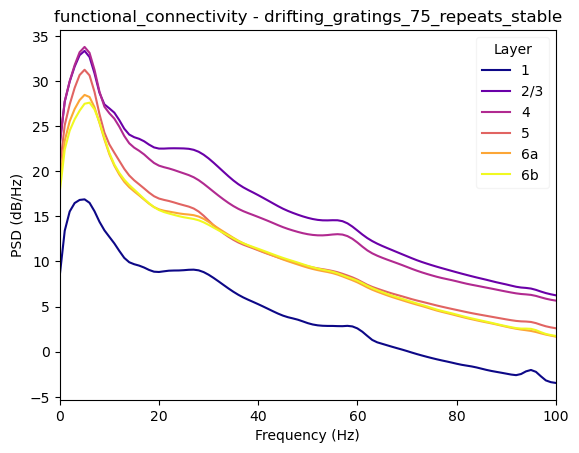

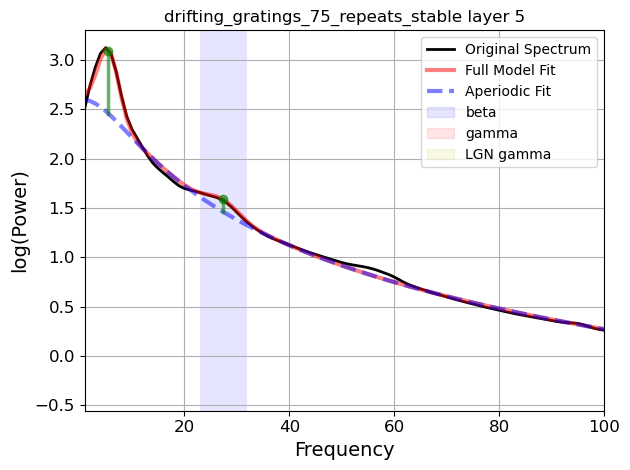

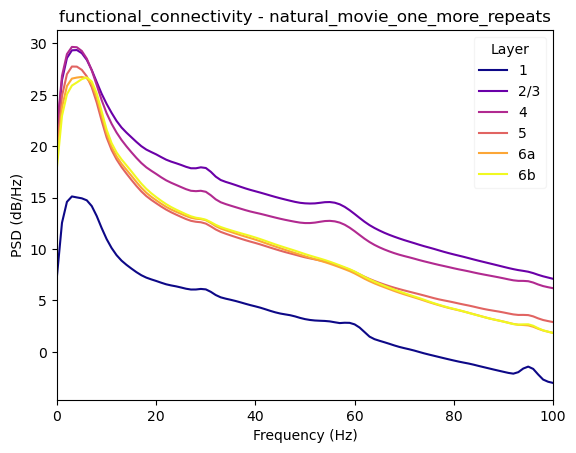

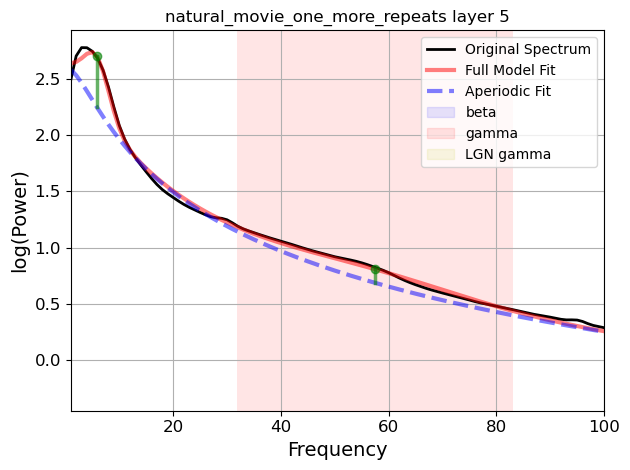

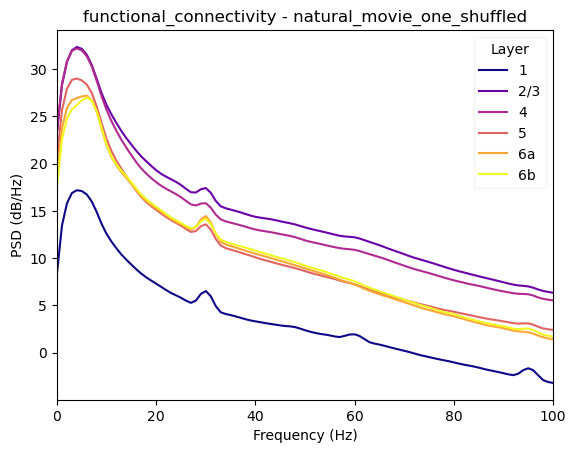

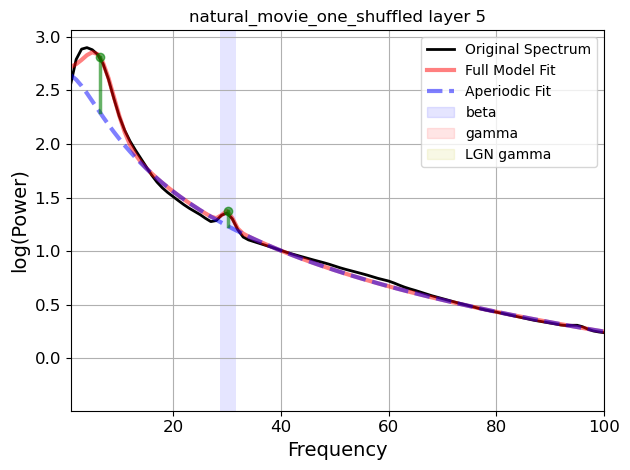

In [93]:
plt_layer = '5'

for session_type, psd_avg_ds in psd_avg.items():
    layers = psd_avg_ds.coords['layer'].values

    if plt_layer not in layers:
        raise ValueError(f"Layer {plt_layer} not found in LFP channels")

    for stim, da in psd_avg_ds.data_vars.items():
        ax = plots.plot_channel_psd(da, channel_dim='layer', freq_range=plt_range)
        ax.set_title(f"{session_type} - {stim}")

        _, ax = plt.subplots(1, 1)
        ax = plots.plot_fooof_quick(fooof_objs[session_type][stim][plt_layer], freq_range=plt_range, ax=ax)

        band = avg_bands_ds[session_type].bands.sel(stimulus=stim, layer=plt_layer)
        ax = plots.plot_freq_band(band, band.wave_band, ax=ax)
        ax.set_title(f"{stim} layer {plt_layer}")

plt.show()

### Show PSD of drifting grating conditions

In [15]:
cond_psd_avg['drifting_gratings']

<xarray.DataArray (orientation: 8, temporal_frequency: 5, contrast: 1,
                   layer: 6, frequency: 626)>
array([[[[[6.95549726e+00, 2.32102642e+01, 3.81216049e+01, ...,
           3.66256689e-03, 3.64098372e-03, 1.80870446e-03],
          [1.29654755e+02, 4.31718567e+02, 7.52076355e+02, ...,
           3.66190332e-03, 3.63586424e-03, 1.80506008e-03],
          [1.51075638e+02, 4.85422913e+02, 8.46238159e+02, ...,
           3.66396457e-03, 3.64011433e-03, 1.80780503e-03],
          [9.52048187e+01, 3.00941956e+02, 5.18656982e+02, ...,
           3.66320414e-03, 3.63608194e-03, 1.80486590e-03],
          [6.07498398e+01, 1.94591568e+02, 3.39526947e+02, ...,
           3.66231357e-03, 3.63838417e-03, 1.80716906e-03],
          [5.77668991e+01, 1.88700806e+02, 3.26809113e+02, ...,
           3.57704563e-03, 3.53595125e-03, 1.75847334e-03]]],


        [[[8.03218365e+00, 2.58717289e+01, 4.10911980e+01, ...,
           3.66896624e-03, 3.65749327e-03, 1.81305176e-03],
          [1.60923599e+02, 5.09285034e+02, 8.53454712e+02, ...,
           3.67454370e-03, 3.65987746e-03, 1.81366608e-03],
          [1.66133545e+02, 5.20823181e+02, 8.85081177e+02, ...,
           3.67264403e-03, 3.65819014e-03, 1.81281997e-03],
...
           3.63490637e-03, 3.59657500e-03, 1.78490579e-03],
          [5.24556885e+01, 1.74644943e+02, 2.95519135e+02, ...,
           3.63559881e-03, 3.59804044e-03, 1.78549567e-03],
          [5.25233917e+01, 1.75160950e+02, 2.99497528e+02, ...,
           3.66690033e-03, 3.69575969e-03, 1.85025041e-03]]],


        [[[6.83598375e+00, 2.29339390e+01, 3.81359215e+01, ...,
           3.65957804e-03, 3.67895002e-03, 1.83580024e-03],
          [1.04948288e+02, 3.52634399e+02, 6.68711731e+02, ...,
           3.66181484e-03, 3.68606625e-03, 1.84085837e-03],
          [1.44076981e+02, 5.09862427e+02, 1.01360205e+03, ...,
           3.65935522e-03, 3.68028739e-03, 1.83753448e-03],
          [1.10691460e+02, 4.09982941e+02, 8.15752014e+02, ...,
           3.66708753e-03, 3.68350931e-03, 1.83787139e-03],
          [7.04455109e+01, 2.50816101e+02, 4.67495697e+02, ...,
           3.66308563e-03, 3.68536822e-03, 1.84012577e-03],
          [7.02041931e+01, 2.43889282e+02, 4.39722992e+02, ...,
           3.47946142e-03, 3.50281061e-03, 1.75268680e-03]]]]],
      dtype=float32)
Coordinates:
  * frequency           (frequency) float64 0.0 1.0 2.0 ... 623.0 624.0 625.0
  * orientation         (orientation) float64 0.0 45.0 90.0 ... 270.0 315.0
  * layer               (layer) object '1' '2/3' '4' '5' '6a' '6b'
  * temporal_frequency  (temporal_frequency) float64 1.0 2.0 4.0 8.0 15.0
  * contrast            (contrast) float64 0.8
Attributes:
    fs:             1250.0
    nperseg:        625
    noverlap:       312
    nseg:           7
    nfft:           1250
    n_dropped:      0
    unit:           uV**2/Hz
    stimulus_name:  drifting_gratings
    n_sessions:     31

In [16]:
stim_cond_psd_das['drifting_gratings']

<xarray.DataArray (session_id: 31, orientation: 8, temporal_frequency: 5,
                   contrast: 1, layer: 6, frequency: 626)>
array([[[[[[8.17574883e+00, 3.11012230e+01, 5.68232422e+01, ...,
            4.68508201e-03, 4.67532687e-03, 2.34357128e-03],
           [1.65268692e+02, 6.56303284e+02, 1.34677856e+03, ...,
            4.68988018e-03, 4.69870307e-03, 2.35803798e-03],
           [1.25683235e+02, 5.18309814e+02, 1.17413074e+03, ...,
            4.68975259e-03, 4.71809600e-03, 2.37898878e-03],
           [9.55810547e+01, 3.94456848e+02, 8.62788147e+02, ...,
            4.74026101e-03, 4.69691586e-03, 2.34315684e-03],
           [4.64134102e+01, 1.57540421e+02, 2.94883484e+02, ...,
            4.69519105e-03, 4.66472423e-03, 2.33252929e-03],
           [6.28484154e+01, 2.06479065e+02, 3.61655304e+02, ...,
            4.71758144e-03, 4.67782188e-03, 2.33608158e-03]]],


         [[[1.09042416e+01, 3.88727570e+01, 7.62498093e+01, ...,
            4.12560534e-03, 3.88877885e-03, 1.89657719e-03],
           [2.23257019e+02, 7.28284302e+02, 1.40195532e+03, ...,
            4.13833093e-03, 3.89993540e-03, 1.90146035e-03],
           [1.41883163e+02, 4.84830841e+02, 9.66514404e+02, ...,
            4.11671679e-03, 3.89810512e-03, 1.90526049e-03],
...
            4.65823989e-03, 4.46751295e-03, 2.20482121e-03],
           [1.96051350e+01, 7.12448959e+01, 1.27896927e+02, ...,
            4.66269301e-03, 4.46490757e-03, 2.19975249e-03],
           [2.63018532e+01, 8.97368317e+01, 1.54894928e+02, ...,
            4.65844665e-03, 4.44318214e-03, 2.18500639e-03]]],


         [[[8.67540836e+00, 2.65177593e+01, 4.26390724e+01, ...,
            4.98834206e-03, 4.99783223e-03, 2.50055594e-03],
           [6.38343582e+01, 2.14528015e+02, 4.12595978e+02, ...,
            5.02090948e-03, 5.05308202e-03, 2.53418437e-03],
           [1.13795029e+02, 4.05422302e+02, 8.11320496e+02, ...,
            4.98755137e-03, 5.00961347e-03, 2.51067709e-03],
           [6.49029922e+01, 2.12824463e+02, 4.19078278e+02, ...,
            5.01061650e-03, 5.02650021e-03, 2.51597399e-03],
           [3.70079994e+01, 1.24448723e+02, 2.25228119e+02, ...,
            4.99605900e-03, 5.02152834e-03, 2.51721824e-03],
           [3.70628433e+01, 1.25996262e+02, 2.20410995e+02, ...,
            4.97184601e-03, 4.98246634e-03, 2.49465229e-03]]]]]],
      dtype=float32)
Coordinates:
  * frequency           (frequency) float64 0.0 1.0 2.0 ... 623.0 624.0 625.0
  * orientation         (orientation) float64 0.0 45.0 90.0 ... 270.0 315.0
  * layer               (layer) object '1' '2/3' '4' '5' '6a' '6b'
  * temporal_frequency  (temporal_frequency) float64 1.0 2.0 4.0 8.0 15.0
  * contrast            (contrast) float64 0.8
    condition_id        (session_id, orientation, temporal_frequency, contrast) float64 ...
  * session_id          (session_id) int64 715093703 719161530 ... 799864342
Attributes:
    nperseg:        625
    noverlap:       312
    nseg:           7
    nfft:           1250
    n_dropped:      0
    unit:           uV**2/Hz
    stimulus_name:  drifting_gratings
    fs:             1250.0

#### Individual sessions

In [ ]:
for session_id in session_list:
    pass

Session: 766640955
Good


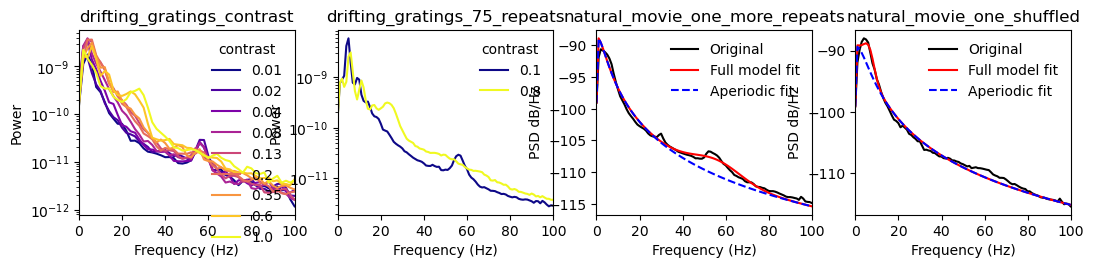

Session: 771160300
Good


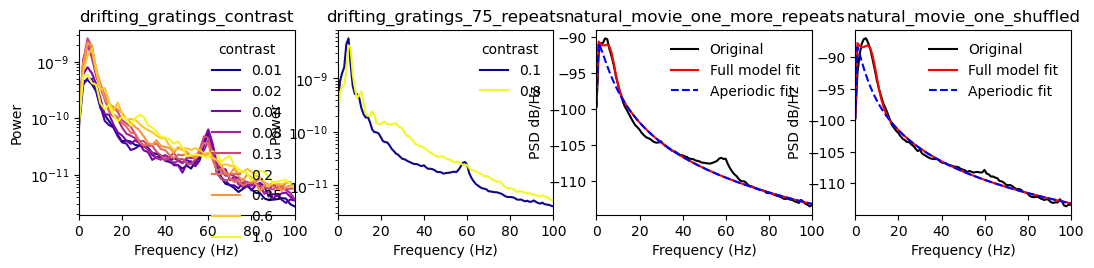

Session: 771990200
Good


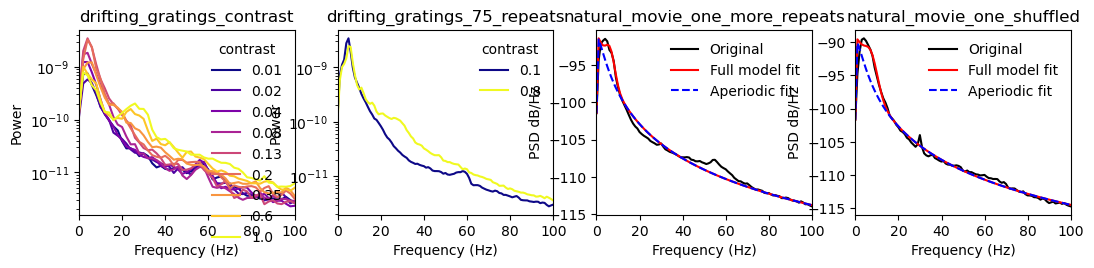

Session: 778240327
Good


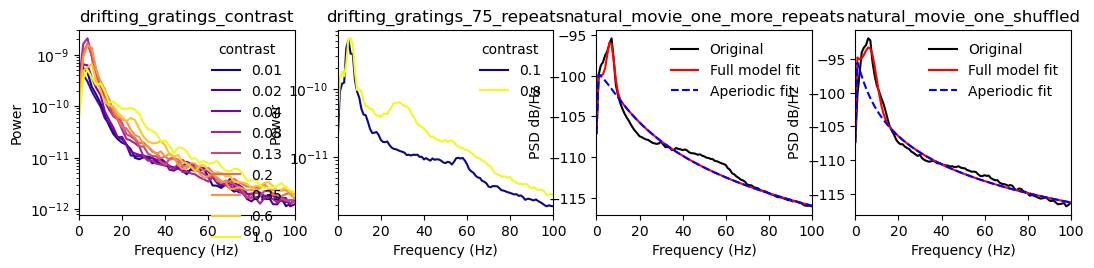

Session: 778998620
Good


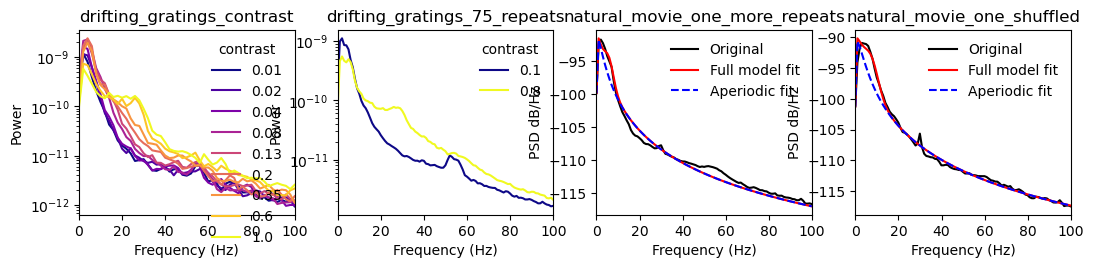

Session: 779839471
Good


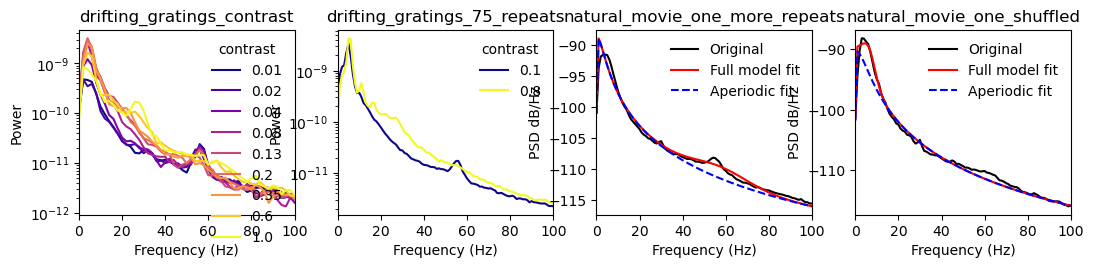

Session: 787025148
Good


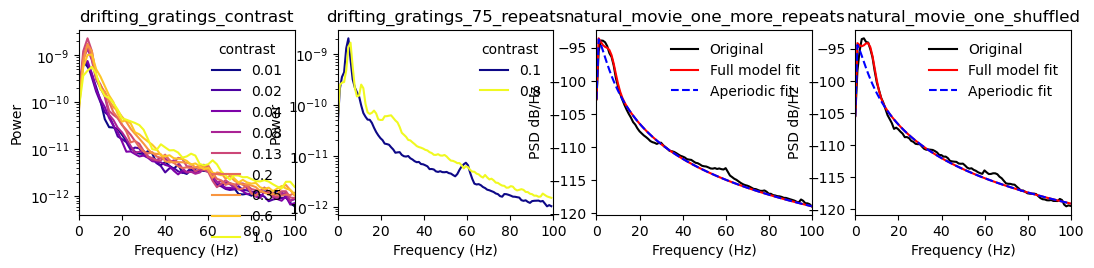

Session: 794812542
Good


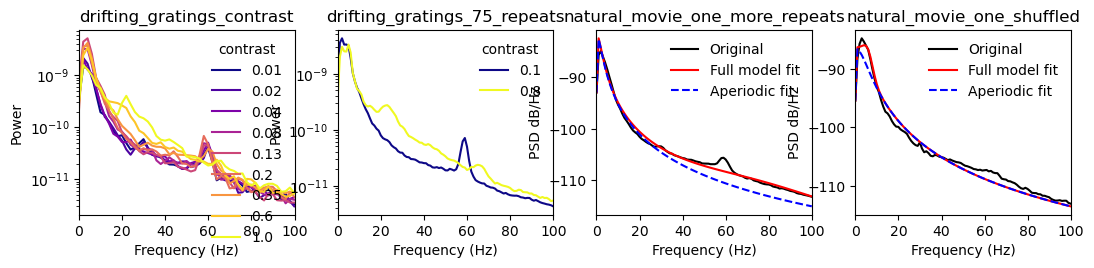

Session: 831882777
Good


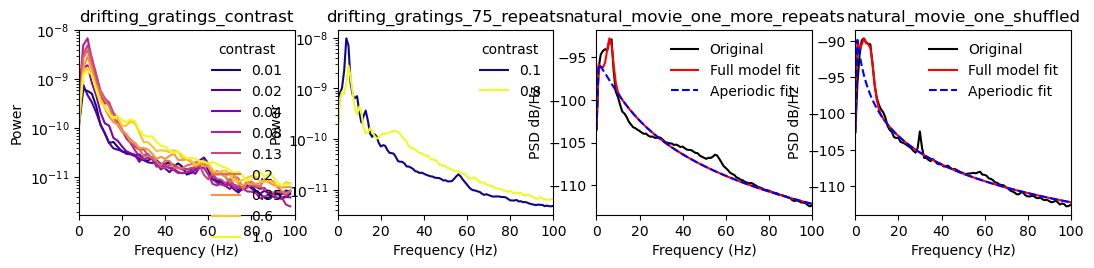

Session: 839068429
Good


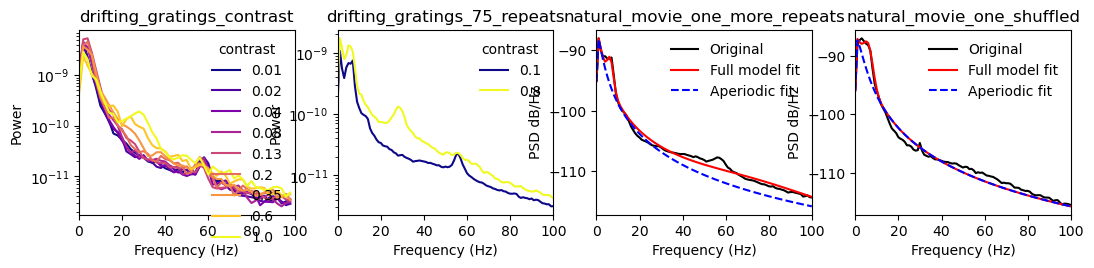

Session: 840012044
Good


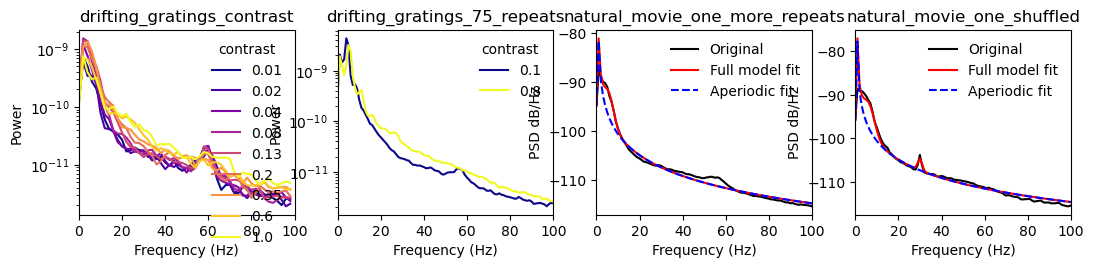

Session: 847657808
Good


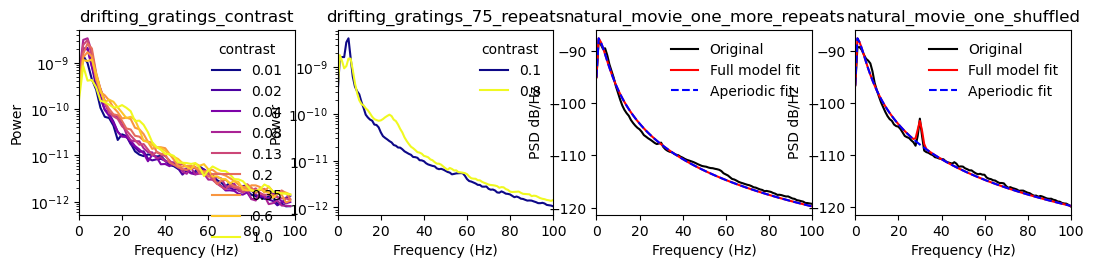

Number of sessions: 12


In [10]:
session_type_filter = ['functional_connectivity']
# session_type_filter = ['brain_observatory_1.1']
stimuli = [['drifting_gratings', 'drifting_gratings_75_repeats', 'drifting_gratings_contrast'],
           ['natural_movie_three', 'natural_movie_one', 'natural_movie_one_more_repeats', 'natural_movie_one_shuffled']]
n_plots = 4
count = 0

for session_id in dg_cond_psd_ds.keys():
    if session_selection.loc[session_id, 'session_type'] not in session_type_filter:
        continue
    print(f'Session: {session_id:d}')
    print('Good' if session_selection.loc[session_id, 'psd good'] else 'Poor')

    fig, axs = plt.subplots(1, n_plots, figsize=(figsize[0] * n_plots, figsize[1]))
    j = 0
    for i, stim_ds in enumerate([dg_cond_psd_ds, psd_ds]):
        ds = stim_ds[session_id]
        group_id = ds.attrs['center_unit_group_id']
        ds = ds.sel(channel=group_id)
        for stim, da in ds.items():
            if stim not in stimuli[i]:
                continue
            ax = axs[j]
            freq_coord = f'frequency_{stim:s}'
            da = da.rename({freq_coord: 'frequency'})
            if i == 0:
                cond_coord = next(iter(set(da.dims).difference(['channel', 'frequency'])))
                cond_name = cond_coord.replace(f'_{stim:s}', '')
                plot_channel_psd(da, channel_coord=cond_coord, channel_name=cond_name,
                                 freq_range=freq_range, plt_range=plt_range, figsize=figsize, ax1=ax,
                                 aperiodic_mode=aperiodic_mode, dB_threshold=dB_threshold, max_n_peaks=max_n_peaks, plt_log=True)
                ax.get_legend().set_frame_on(False)
            else:
                fooof_result = fit_fooof(da.frequency.values, da.values,
                    aperiodic_mode=aperiodic_mode, dB_threshold=dB_threshold, max_n_peaks=max_n_peaks,
                    freq_range=freq_range, peak_width_limits=None, report=False, plot=False)

                psd_avg_plt = da.sel(frequency=slice(*plt_range))
                _ = plot_fooof(psd_avg_plt.frequency.values, psd_avg_plt.values, fooof_result[0], plt_log=False, plt_range=plt_range, plt_db=True, ax=ax)
            ax.set_title(stim)
            j += 1
    plt.show()
    count += 1

print(f'Number of sessions: {count:d}')

#### Average over sessions


drifting_gratings: 18 sessions


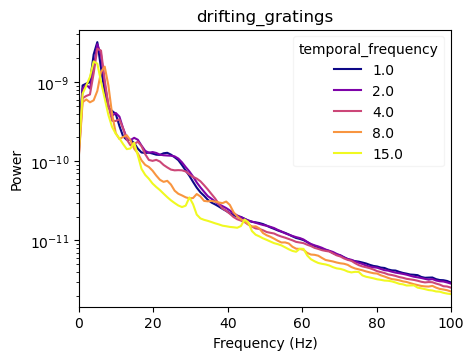


drifting_gratings_75_repeats: 12 sessions


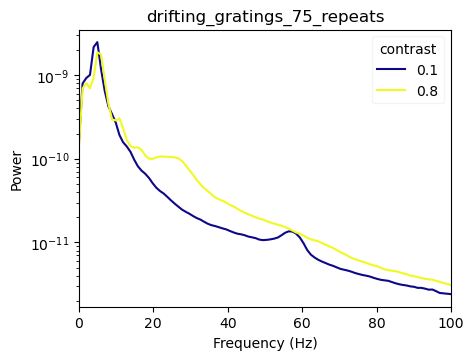


drifting_gratings_contrast: 12 sessions


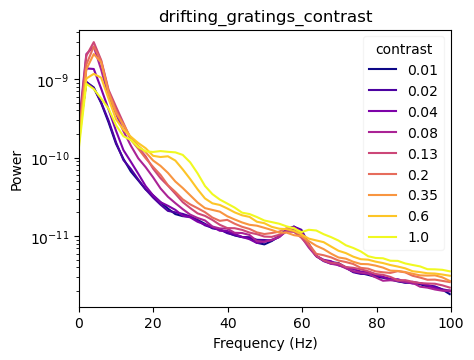

In [ ]:
stimuli = ['drifting_gratings', 'drifting_gratings_75_repeats', 'drifting_gratings_contrast']

for stim in stimuli:
    psd_avg = average_psd_across_sessions(dg_cond_psd_ds, stim)
    if psd_avg is None:
        continue

    cond_coord = next(iter(set(psd_avg.dims).difference(['frequency'])))
    cond_name = cond_coord.replace(f'_{stim:s}', '')
    _, fig1, _ = plot_channel_psd(psd_avg, channel_coord=cond_coord, channel_name=cond_name,
                                  freq_range=freq_range, plt_range=plt_range, figsize=np.array(figsize) * 1.5,
                                  aperiodic_mode=aperiodic_mode, dB_threshold=dB_threshold, max_n_peaks=max_n_peaks, plt_log=True)
    fig1.get_axes()[0].set_title(f'{stim:s}')
    plt.show()

    # fig_name = os.path.join(fig_dir, f"{stim}_psd_avg" + ext)
    # fig1.savefig(fig_name, **savefig_kwargs)

### Show PSD of stimuli

#### Filter drifting grating conditions

In [12]:
contrast_filter = lambda x: x > 0.5
tempfreq_filter = lambda x: x < 5

condition_filters = dict(
    drifting_gratings_contrast = contrast_filter,
    drifting_gratings_75_repeats = contrast_filter,
    drifting_gratings = tempfreq_filter
)

In [13]:
for session_id, ds in psd_ds.items():
    for stim in ds.keys():
        if stim not in condition_filters:
            continue
        da = dg_cond_psd_ds[session_id][stim]
        freq_coord = f'frequency_{stim:s}'
        cond_coord = next(iter(set(da.dims).difference(['channel', freq_coord])))
        cond_idx = condition_filters[stim](da.coords[cond_coord])  # filter condition
        da = da.sel({cond_coord: cond_idx}).mean(dim=cond_coord)
        ds = ds.assign({stim: da})  # replace with psd averaged over conditions
        psd_ds[session_id] = ds

#### Select stimuli

In [14]:
stimuli = ['drifting_gratings', 'natural_movie_three', 'natural_movie_one',
           'drifting_gratings_75_repeats', 'drifting_gratings_contrast',
           'natural_movie_one_more_repeats', 'natural_movie_one_shuffled']

#### Calculate average PSD


drifting_gratings: 18 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 0.99 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -6.8151, 176.0737, 2.3340                                     
                                                                                                  
                                       1 peaks were found:                   

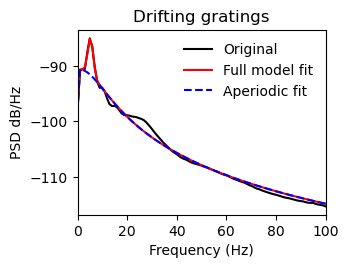


natural_movie_three: 18 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -8.0698, 9.9619, 1.7429                                      
                                                                                                  
                                       1 peaks were found:                 

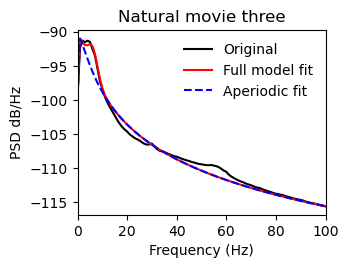


natural_movie_one: 18 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -8.0502, 11.0375, 1.7527                                     
                                                                                                  
                                       1 peaks were found:                   

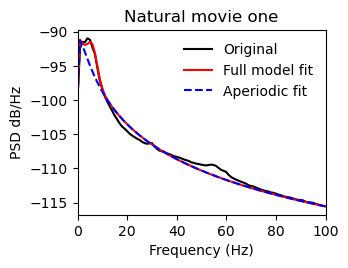


drifting_gratings_75_repeats: 12 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 0.99 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -6.7877, 272.2559, 2.3377                                     
                                                                                                  
                                       1 peaks were found:        

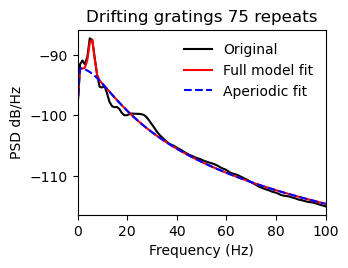


drifting_gratings_contrast: 12 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 200 Hz                        
                                 Frequency Resolution is 1.99 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0664, 72.9933, 2.1920                                     
                                                                                                  
                                       0 peaks were found:          

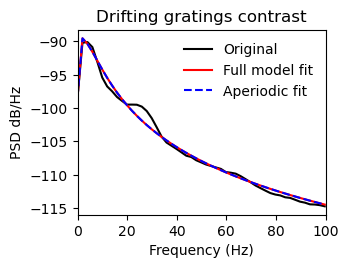


natural_movie_one_more_repeats: 12 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.9984, 14.0967, 1.7728                                     
                                                                                                  
                                       1 peaks were found:      

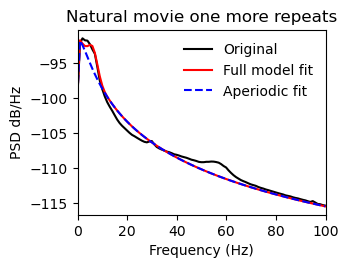


natural_movie_one_shuffled: 12 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.9837, 8.1652, 1.7846                                      
                                                                                                  
                                       1 peaks were found:          

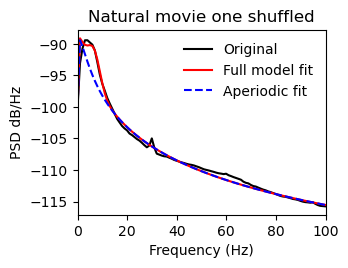

In [ ]:
for stim in stimuli:
    psd_avg = average_psd_across_sessions(psd_ds, stim)
    if psd_avg is None:
        continue

    fooof_result = fit_fooof(psd_avg.frequency.values, psd_avg.values,
        aperiodic_mode=aperiodic_mode, dB_threshold=dB_threshold, max_n_peaks=max_n_peaks,
        freq_range=freq_range, peak_width_limits=None, report=True, plot=False)

    fig, ax = plt.subplots(figsize=figsize)
    psd_avg_plt = psd_avg.sel(frequency=slice(*plt_range))
    _ = plot_fooof(psd_avg_plt.frequency.values, psd_avg_plt.values, fooof_result[0], plt_log=False, plt_range=plt_range, plt_db=True, ax=ax)
    ax.set_title(stim.replace('_', ' ').capitalize())
    plt.show()

    # fig_name = os.path.join(fig_dir, f"{stim}_psd_fooof_conditions_filtered" + ext)
    # fig.savefig(fig_name, **savefig_kwargs)